# Lagrange Model

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [26]:
# load dataset
# add a new column 'Bird(m/s)'*'Blade(rad/s)' as BirdxBlade
data_raw = pd.read_csv('LagrangeJournalBirdStrikeValueupto50.csv')
data_raw['BirdxBlade'] = data_raw['Bird(m/s)'] * data_raw['Blade(rad/s)']

In [27]:
data_raw.describe()

,test_set,Bird(m/s),Blade(rad/s),Max_TD(mm),Von_Mises_Stress(pascal),Total_Energy,BirdxBlade
count,49.00000,49.000000,49.000000,49.000000,4.900000e+01,4.900000e+01,49.000000
mean,25.00000,182.500000,515.000000,0.670000,1.167274e+09,1.821396e+06,96487.500000
std,14.28869,35.721725,71.443451,0.188392,4.449917e+07,5.044295e+05,31516.098317
min,1.00000,122.500000,395.000000,0.350000,1.059400e+09,1.037200e+06,48387.500000
25%,13.00000,152.500000,455.000000,0.490000,1.151850e+09,1.390000e+06,69387.500000
50%,25.00000,182.500000,515.000000,0.740000,1.172436e+09,1.787100e+06,93987.500000
75%,37.00000,212.500000,575.000000,0.830000,1.195846e+09,2.234322e+06,122187.500000
max,49.00000,242.500000,635.000000,0.950000,1.276456e+09,2.731651e+06,153987.500000


# Plot outputs

MAX_TD(mm)

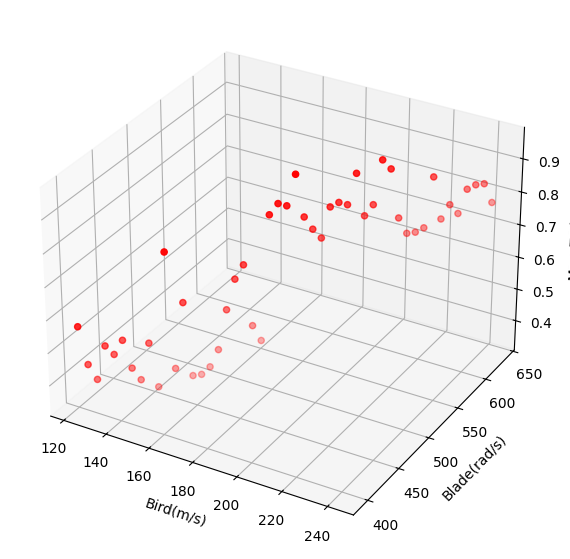

In [5]:
# plot MAX_TD vs Bird and Blade
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_raw['Bird(m/s)'], data_raw['Blade(rad/s)'], data_raw['Max_TD(mm)'], c='r', marker='o')
ax.set_xlabel('Bird(m/s)')
ax.set_ylabel('Blade(rad/s)')
ax.set_zlabel('Max_TD(mm)')
plt.show()

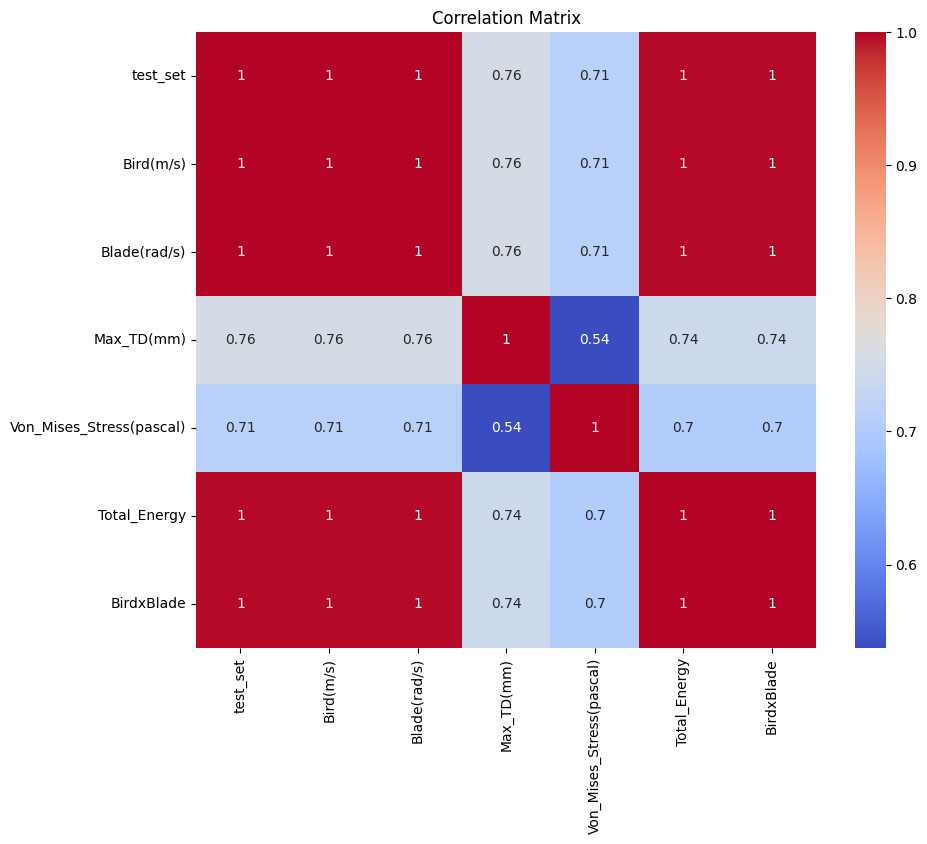

In [28]:
# Plot the correlation matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
correlation_matrix = data_raw.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 1. Random Forest Regressor (RF)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X = data_raw[['Bird(m/s)', 'Blade(rad/s)']]
y = data_raw['Max_TD(mm)']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf_model = RandomForestRegressor(
    n_estimators=21,
    random_state=42,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=2,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print(f"MSE  : {mse:.4f}")

print ("\n k mean cross validation \n")

# Do K mean cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
    n_estimators=21,
    random_state=42,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=2,
    n_jobs=-1
    )
    
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf = rf_model_kf.predict(X_test_kf)
    
    mse_kf = mean_squared_error(y_test_kf, y_pred_kf)
    r2_kf = r2_score(y_test_kf, y_pred_kf)
    rmse_kf = np.sqrt(mse_kf)
    rmse_list.append(rmse_kf)
average_rmse = np.mean(rmse_list)
print(f"Average RMSE from K-Fold CV: {average_rmse:.4f}")
print(f"RMSEs from each fold: {rmse_list}")
print(f"R²   : {r2_kf:.4f}")
print(f"MSE  : {mse_kf:.4f}")

# At fold 4 :
# likely at very high or very low speeds the model finds harder to predict.

# Feature imporatnace in number format
importances = rf_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(feature_importance_df)

# 0.64 is a more honest representation of how the model performs on average across all your data
# The "Fold 4" Culprit: That fold with an RMSE of 0.1374 is dragging your average down. This suggests 
# that about 20% of your data contains a physical interaction (perhaps very high-speed impacts) that the current model hasn't fully mastered yet.

# taking two features bird and blade only 

# when n_estiators =25

# RMSE : 0.0749
# R²   : 0.7703
# MSE  : 0.0056

# k mean cross validation 
# Average RMSE from K-Fold CV: 0.0953
# RMSEs from each fold: [np.float64(0.08913012650879566), np.float64(0.073304580672518), np.float64(0.07807633358195619), np.float64(0.1374471583838876), np.float64(0.09831298412849104)]
# R²   : 0.6438
# MSE  : 0.0097

# Feature Importances:
#         Feature  Importance
# 0     Bird(m/s)    0.551088
# 1  Blade(rad/s)    0.448912

# taking three features bird, blade and birdxblade
#  same nothing changed

# # when n_estiators =21
# RMSE : 0.0728
# R²   : 0.7827
# MSE  : 0.0053

#  k mean cross validation 

# Average RMSE from K-Fold CV: 0.0938
# RMSEs from each fold: [np.float64(0.08675055799223216), np.float64(0.0716147712044915), np.float64(0.07878296203386362), np.float64(0.13575451875609817), np.float64(0.09627517065806993)]
# R²   : 0.6584
# MSE  : 0.0093


RMSE : 0.0728
R²   : 0.7827
MSE  : 0.0053

 k mean cross validation 

Average RMSE from K-Fold CV: 0.0938
RMSEs from each fold: [np.float64(0.08675055799223216), np.float64(0.0716147712044915), np.float64(0.07878296203386362), np.float64(0.13575451875609817), np.float64(0.09627517065806993)]
R²   : 0.6584
MSE  : 0.0093

Feature Importances:
        Feature  Importance
0     Bird(m/s)    0.608833
1  Blade(rad/s)    0.391167


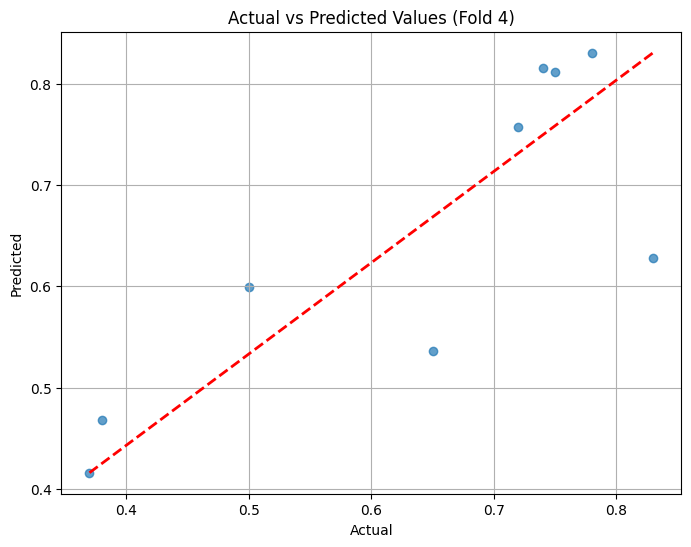

In [33]:
# Residual Analysis
# To solve the "Fold 4" mystery, we need to see where the model fails.
# Action: Plot your Actual vs. Predicted values.
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_kf, y_pred_kf, alpha=0.7)
plt.plot([y_test_kf.min(), y_test_kf.max()], [y_pred_kf.min(), y_pred_kf.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Fold 4)')
plt.grid(True)
plt.show()

The "Fold 4" Diagnosis:
- The Major Outlier: Look at the point on the far right (Actual $\approx$ 0.83). The model predicted it at roughly 0.63. This is a massive under-estimation. Because this point is so far from the red line, it is likely single-handedly tanking your MSE/R-squared for this fold.
- Over-estimation at the Top: For actual values between 0.7 and 0.8, almost all your blue dots are above the red line. This means the model is consistently over-predicting in that specific range.
- Low Sample Size: I see only about 8 or 9 data points. In a fold this small, one bad prediction (like that 0.83 value) has a disproportionate impact on the "success" of the fold.

# 2. Gaussian Process Regression (GPR)

In [20]:
# Gaussian Process Regression (GPR) model to predict Max_TD same as random forest model above
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
scaler = StandardScaler()

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
gpr_model.fit(X_train, y_train)
y_pred_gpr = gpr_model.predict(X_test)
mse_gpr = mean_squared_error(y_test, y_pred_gpr)
r2_gpr = r2_score(y_test, y_pred_gpr)
print(f'GPR Model - MSE: {mse_gpr:.4f}')
print(f'GPR Model - RMSE: {np.sqrt(mse_gpr):.4f}')
print(f'GPR R² Score: {r2_gpr:.4f}')
y_train_scaled = scaler.fit_transform(X_train)
y_test_scaled = scaler.transform(X_test)

# k fold cross validation for GPR
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list_gpr = []
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
    
    gpr_model_kf = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
    
    gpr_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_gpr = gpr_model_kf.predict(X_test_kf)
    
    mse_kf_gpr = mean_squared_error(y_test_kf, y_pred_kf_gpr)
    r2_kf_gpr = r2_score(y_test_kf, y_pred_kf_gpr)
    rmse_kf_gpr = np.sqrt(mse_kf_gpr)
    rmse_list_gpr.append(rmse_kf_gpr)
average_rmse_gpr = np.mean(rmse_list_gpr)
print(f"Average RMSE from K-Fold CV (GPR): {average_rmse_gpr:.4f}")
print(f"RMSEs from each fold (GPR): {rmse_list_gpr}")
print(f"R²   : {r2_kf_gpr:.4f}")
print(f"MSE  : {mse_kf_gpr:.4f}")

# feature importance is not directly available for GPR models



c:\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GPR Model - MSE: 0.0076
GPR Model - RMSE: 0.0872
GPR R² Score: 0.6883
Average RMSE from K-Fold CV (GPR): 0.1018
RMSEs from each fold (GPR): [np.float64(0.08724883591482), np.float64(0.0775045567496176), np.float64(0.08323546981713863), np.float64(0.15802958609474735), np.float64(0.1031381783951791)]
R²   : 0.6080
MSE  : 0.0106


c:\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


# 3. Support Vector Regression (SVR) with RBF Kernel

In [36]:
# Prepare features and target
X = data_raw[['Bird(m/s)', 'Blade(rad/s)']]
y = data_raw['Max_TD(mm)']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVR model
model = SVR(kernel='rbf', C=160, gamma= 1, epsilon=0.1)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

# model = SVR(kernel='rbf', C=160, gamma= 0.2, epsilon=0.1)
# Mean Squared Error: 0.0053
# RMSE: 0.0729
# R² Score: 0.7825

# k fold cross validation for SVR
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list_svr = []
for train_index, test_index in kf.split(X): 
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
    
    # Standardize features for each fold
    scaler_kf = StandardScaler()
    X_train_kf_scaled = scaler_kf.fit_transform(X_train_kf)
    X_test_kf_scaled = scaler_kf.transform(X_test_kf)
    
    svr_model_kf = SVR(kernel='rbf', C=160, gamma= 1, epsilon=0.1)
    
    svr_model_kf.fit(X_train_kf_scaled, y_train_kf)
    y_pred_kf_svr = svr_model_kf.predict(X_test_kf_scaled)
    
    mse_kf_svr = mean_squared_error(y_test_kf, y_pred_kf_svr)
    r2_kf_svr = r2_score(y_test_kf, y_pred_kf_svr)
    rmse_kf_svr = np.sqrt(mse_kf_svr)
    rmse_list_svr.append(rmse_kf_svr)
average_rmse_svr = np.mean(rmse_list_svr)
print(f"\nAverage RMSE from K-Fold CV (SVR): {average_rmse_svr:.4f}")
print(f"RMSEs from each fold (SVR): {rmse_list_svr}")
print(f"R²   : {r2_kf_svr:.4f}")
print(f"MSE  : {mse_kf_svr:.4f}")

# fearture importance is not directly available for SVR models

Mean Squared Error: 0.0062
RMSE: 0.0790
R² Score: 0.7447

Average RMSE from K-Fold CV (SVR): 0.0949
RMSEs from each fold (SVR): [np.float64(0.07893859259118771), np.float64(0.08417216673948134), np.float64(0.07048057903058474), np.float64(0.1422746140206538), np.float64(0.0984710597488287)]
R²   : 0.6427
MSE  : 0.0097


In [11]:
# Example prediction
example_data = np.array([[132, 400]])  # Example: Bird speed = 132 m/s, Blade speed = 400 rad/s
example_data_scaled = scaler.transform(example_data)
predicted_max_td = model.predict(example_data_scaled)
print(f'Predicted Max_TD(mm) for Bird=132 m/s and Blade=400 rad/s: {predicted_max_td[0]:.4f} mm')

Predicted Max_TD(mm) for Bird=132 m/s and Blade=400 rad/s: 0.4810 mm


C:\Users\MTBD\AppData\Roaming\Python\Python314\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# 4. Polynomial Regression

In [35]:
# polynomial regression model to predict Max_TD
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)
lin_reg.fit(X_train_poly, y_train)
y_pred_poly = lin_reg.predict(X_test_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f'Polynomial Regression Model - MSE: {mse_poly:.4f}')
print(f'Polynomial Regression Model - RMSE: {np.sqrt(mse_poly):.4f}')
print(f'Polynomial Regression R² Score: {r2_poly:.4f}')

# k fold cross validation for polynomial regression
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list_poly = []
for train_index, test_index in kf.split(X_poly):
    X_train_kf, X_test_kf = X_poly[train_index], X_poly[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
    
    lin_reg_kf = LinearRegression()
    
    lin_reg_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_poly = lin_reg_kf.predict(X_test_kf)
    
    mse_kf_poly = mean_squared_error(y_test_kf, y_pred_kf_poly)
    r2_kf_poly = r2_score(y_test_kf, y_pred_kf_poly)
    rmse_kf_poly = np.sqrt(mse_kf_poly)
    rmse_list_poly.append(rmse_kf_poly)
average_rmse_poly = np.mean(rmse_list_poly)
print(f"\nAverage RMSE from K-Fold CV (Polynomial Regression): {average_rmse_poly:.4f}")
print(f"RMSEs from each fold (Polynomial Regression): {rmse_list_poly}")
print(f"R²   : {r2_kf_poly:.4f}")
print(f"MSE  : {mse_kf_poly:.4f}")

# feature importance is not directly available for polynomial regression models

Polynomial Regression Model - MSE: 0.0051
Polynomial Regression Model - RMSE: 0.0717
Polynomial Regression R² Score: 0.7894

Average RMSE from K-Fold CV (Polynomial Regression): 0.1029
RMSEs from each fold (Polynomial Regression): [np.float64(0.07171688484828252), np.float64(0.07624955399084642), np.float64(0.09510036146416434), np.float64(0.16913623382315437), np.float64(0.10239005906844442)]
R²   : 0.6137
MSE  : 0.0105


# 5. XGBoost

In [ ]:
# XgBoost model to predict Max_TD
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    n_estimators=21,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'XGBoost Model - MSE: {mse_xgb:.4f}')
print(f'XGBoost Model - RMSE: {np.sqrt(mse_xgb):.4f}')
print(f'XGBoost R² Score: {r2_xgb:.4f}')

# k fold cross validation for XGBoost
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list_xgb = []
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
    
    xgb_model_kf = xgb.XGBRegressor(
        n_estimators=21,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    
    xgb_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)
    
    mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
    r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)
    rmse_kf_xgb = np.sqrt(mse_kf_xgb)
    rmse_list_xgb.append(rmse_kf_xgb)
average_rmse_xgb = np.mean(rmse_list_xgb)
print(f"\nAverage RMSE from K-Fold CV (XGBoost): {average_rmse_xgb:.4f}")
print(f"RMSEs from each fold (XGBoost): {rmse_list_xgb}")
print(f"R²   : {r2_kf_xgb:.4f}")
print(f"MSE  : {mse_kf_xgb:.4f}")
# Feature importance for XGBoost
importances = xgb_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)
print("\nXGBoost Feature Importances:")
print(feature_importance_df_xgb)

# when n_estimators=23
# R2 = 0.7066
# k R2 = 0.4582 

# when n_estimators=20
# R2 = 0.6877
# k R2 = 0.4668

# when n_estimators=21
# R2 = 0.6983
# k R2 = 0.4762

XGBoost Model - MSE: 0.0074
XGBoost Model - RMSE: 0.0858
XGBoost R² Score: 0.6983

Average RMSE from K-Fold CV (XGBoost): 0.1009
RMSEs from each fold (XGBoost): [np.float64(0.08564736437147061), np.float64(0.07815282162945897), np.float64(0.07641890767923497), np.float64(0.144908544821756), np.float64(0.11921586314528594)]
R²   : 0.4762
MSE  : 0.0142

XGBoost Feature Importances:
        Feature  Importance
1  Blade(rad/s)    0.531558
0     Bird(m/s)    0.468442
